In [15]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import minimize

import matplotlib.pyplot as plt

info_path = "data/info.csv"
data = pd.read_csv(info_path, index_col=0, usecols=[0,1,2,3], skiprows=1, parse_dates=True, names=['date', 'bond', 'stock','rate'])
data.index = pd.DatetimeIndex(data.index, freq='W-MON')
data = data[data.index.year<2024]
data['rate'] = data['rate'] / 100 /52
returns = data.pct_change().dropna()

##--------------------------------------------## part 1 Static allocation ##--------------------------------------------## 
returns = np.array(returns[['stock', 'bond']])
Lambda = [2,10]
static_allocation_L2 = None
static_allocation_L10 = None

for L in Lambda:
    N = data.shape[0]
    mu = returns.mean(axis = 0)
    Sigma = (returns - mu).T @ (returns - mu) / N
    R_f = data['rate'].mean()
    e = np.ones([1,2])
    Sigma_inv = np.linalg.inv(Sigma)
    alpha_tilde = 1/L * Sigma_inv @ (mu - e * R_f).T
    alpha_tilde = np.append(alpha_tilde , 1 - e @ alpha_tilde)
    if L == 2:
        static_allocation_L2 = alpha_tilde
    elif L == 10:
        static_allocation_L10 = alpha_tilde
print(static_allocation_L2) #[sp500, bond, rf]
print(static_allocation_L10) #[sp500, bond, rf]


## returns [sp, dax, rf]
returns = data.pct_change().bfill()
returns['rate']= data['rate']
returns = np.array(returns[['stock', 'bond', 'rate']]) 


static_returns_L2 = np.sum(static_allocation_L2 * returns, axis=1)
static_returns_cum_L2 = np.cumprod(static_returns_L2 + 1) - 1

static_returns_L10 = np.sum(static_allocation_L10 * returns, axis=1)
static_returns_cum_L10 = np.cumprod(static_returns_L10 + 1) - 1


log_static_returns_L2 = np.log(1 + static_returns_L2)
log_static_returns_cum_L2 = np.cumsum(log_static_returns_L2)

log_static_returns_L10 = np.log(1 + static_returns_L10)
log_static_returns_cum_L10 = np.cumsum(log_static_returns_L10)

##--------------------------------------------## part 2 Estimation of a GARCH model ##--------------------------------------------##
#Q2.1

returns = data.pct_change().bfill()
returns['rate']= data['rate']
returns_sp500 = returns['stock']
returns_dax = returns['bond']
excess_returns_sp500 = returns_sp500 - data['rate']
excess_returns_sp500 = excess_returns_sp500.dropna()
excess_returns_dax = returns_dax - data['rate']
excess_returns_dax = excess_returns_dax.dropna()
squared_excess_returns_sp500 = ((returns_sp500 - data['rate'])**2).dropna()
squared_excess_returns_dax = ((returns_dax - data['rate'])**2).dropna()


# Kolmogorov-Smirnov tests for normality
ks_excess_sp500 = stats.kstest(excess_returns_sp500, 'norm', args=(excess_returns_sp500.mean(), excess_returns_sp500.std()))
ks_excess_dax = stats.kstest(excess_returns_dax, 'norm', args=(excess_returns_dax.mean(), excess_returns_dax.std()))

ks_sqrdexcess_sp500 = stats.kstest(squared_excess_returns_sp500, 'norm', args=(squared_excess_returns_sp500.mean(), squared_excess_returns_sp500.std()))
ks_sqrdexcess_dax = stats.kstest(squared_excess_returns_dax, 'norm', args=(squared_excess_returns_dax.mean(), squared_excess_returns_dax.std()))

print('KS excess sp500:', ks_excess_sp500)
print('KS excess dax:', ks_excess_dax)
print('KS squared excess sp500:', ks_sqrdexcess_sp500)
print('KS squared excess dax:', ks_sqrdexcess_dax)

# Ljung-Box tests for autocorrelation on returns
lb_excess_sp500 = acorr_ljungbox(excess_returns_sp500, lags=[4], return_df=True)
lb_excess_dax = acorr_ljungbox(excess_returns_dax, lags=[4], return_df=True)

dax_autocorr = acorr_ljungbox(returns_dax, lags = [4], return_df=True)
sp_auto_corr = acorr_ljungbox(returns_sp500, lags = [4], return_df=True)

# Ljung-Box tests for autocorrelation on squared returns
ljung_box_sq_sp500 = acorr_ljungbox(squared_excess_returns_sp500, lags=[4], return_df=True)
ljung_box_sq_dax = acorr_ljungbox(squared_excess_returns_dax, lags=[4], return_df=True)


#Q2.2
ar1_dax = AutoReg(returns_dax, lags=1).fit()
# print('daxdax', ar1_dax.summary())
ar1_sp500 = AutoReg(returns_sp500, lags=1).fit()
# print('spsp', ar1_sp500.summary())
ar1_dax_summary = ar1_dax.summary()
ar1_sp500_summary = ar1_sp500.summary()
residuals_dax = np.array(ar1_dax.resid)
residuals_sp500 = np.array(ar1_sp500.resid)
ar1_sp500_intercept = ar1_sp500.params[0]
ar1_sp500_slope = ar1_sp500.params[1]
ar1_dax_intercept = ar1_dax.params[0]
ar1_dax_slope = ar1_dax.params[1]


def garch_log_likelihood(params, returns, residuals): # objective function to minimize
    n = len(residuals)
    omega, alpha, beta = params
    sigma_squared = np.zeros(n)
    epsilon = residuals.copy()
    log_likelihood = 0
    sigma_squared[0] = sum(residuals**2) / len(residuals)

    for t in range(1, n):
        sigma_squared[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma_squared[t-1]
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(sigma_squared[t]) + epsilon[t]**2 / sigma_squared[t])
    return -log_likelihood

def estimate_garch_parameters(returns:pd.DataFrame, residuals:int):
    initial_params = [0.00001, 0.05, 0.90]  # omega, alpha, beta
    bounds = [(0, +np.inf), (0.0001, 1), (0.0001, 1)]
    result = minimize(garch_log_likelihood, initial_params, args=(returns, residuals),
                      method='Nelder-Mead',  bounds = bounds) ## Nelder-Mead for scalar minimization
    return result.x

def garch_variance(params, residuals):
    n = len(residuals)
    omega, alpha, beta = params
    sigma_squared = np.zeros(n)
    sigma_squared[0] = sum(residuals**2) / n  # Initial variance estimate

    for t in range(1, n):
        sigma_squared[t] = omega + alpha * residuals[t-1]**2 + beta * sigma_squared[t-1]
    return sigma_squared


# Use the function
params_sp = estimate_garch_parameters(returns_sp500, residuals_sp500)
print(params_sp)
params_dax = estimate_garch_parameters(returns_dax, residuals_dax)
print(params_dax)

sp_garch_variance = garch_variance(params_sp, residuals_sp500)
dax_garch_variance = garch_variance(params_dax, residuals_dax)

def garch_wald_test(params, fisher_info, confidence_level=0.95):
    T = len(residuals_sp500)
    asympt_var = np.linalg.inv(fisher_info)
    _, alpha, beta = params
    alpha_beta = alpha + beta
    alpha_beta_var = asympt_var[1, 1] + asympt_var[2, 2] + 2 * asympt_var[1, 2]
    wald = T * (alpha_beta - 1) ** 2 / alpha_beta_var
    critical_value = stats.chi2.ppf(confidence_level, 1)
    print("Wald Test Statistic:", wald)
    print("Critical value (chi-square with 1 df):", critical_value)
    print("SQRT WALD", np.sqrt(wald))
    if wald > critical_value:
        print("Reject the null hypothesis that alpha + beta = 1.")
    else:
        print("Do not reject the null hypothesis.")

def garch_t_test(params, fisher_info, confidence_level=0.95):
    T = len(residuals_sp500)
    sigma = np.linalg.inv(fisher_info)
    alpha_beta_se_2 = (sigma[1, 1] + sigma[2, 2] + 2 * sigma[1, 2])
    alpha_beta = params[1] + params[2]
    t_stat = np.sqrt(T) * (alpha_beta - 1) / np.sqrt(alpha_beta_se_2)
    critical_value = stats.norm.ppf(confidence_level)
    print("T Test Statistic:", t_stat)
    print("Critical value :", critical_value)
    if abs(t_stat) > critical_value:
        print("Reject the null hypothesis that alpha + beta = 1.")
    else:
        print("Do not reject the null hypothesis.")

# TWO WAYS OF COMPUTING THE ASYMPTOTIC VARIANCE

def garch_asymptotic_variance(params, residuals):
    T = len(residuals)
    sigma2 = garch_variance(params, residuals)
    eps = residuals
    asympt_var = np.matrix([[0.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0]])
    for t in range(T-1):
        a = 1 / (sigma2[t+1] ** 2)
        b = np.matrix([[1,           eps[t] ** 2,             sigma2[t]],
                       [eps[t] ** 2, eps[t] ** 4,             eps[t] ** 2 * sigma2[t]],
                       [sigma2[t],   eps[t] ** 2 * sigma2[t], sigma2[t] ** 2]])
        asympt_var += a * b
    return 1 / (2*T) * asympt_var

method1_sp_fisher = garch_asymptotic_variance(params_sp, residuals_sp500)
method1_dax_fisher = garch_asymptotic_variance(params_dax, residuals_dax)

garch_t_test(params_sp, method1_sp_fisher)
garch_t_test(params_dax, method1_dax_fisher)

garch_wald_test(params_sp, method1_sp_fisher)
garch_wald_test(params_dax, method1_dax_fisher)


##--------------------------------------------## part 3 Dynamic Allocation ##--------------------------------------------##
correlation_sp_dax = np.correlate(residuals_dax, residuals_sp500)

def expected_return(intercept, rho, returns):
    return intercept + rho * returns

def expected_covariance(correlation, sigma1, sigma2):
    return correlation * sigma1 * sigma2

exp_returns_sp = expected_return(ar1_sp500_intercept, ar1_sp500_slope, returns_sp500)
exp_returns_dax = expected_return(ar1_dax_intercept, ar1_dax_slope, returns_dax)

exp_var_sp = expected_covariance(correlation_sp_dax, np.sqrt(sp_garch_variance), np.sqrt(dax_garch_variance))
covariance_matrix_tp1 = np.array([[sp_garch_variance, exp_var_sp], [exp_var_sp, dax_garch_variance]])

## computation + plot
alpha_tilde_dynamic = np.array([0.5, 0.5])
e = np.ones(len(alpha_tilde_dynamic))
R_f = data['rate']
mu = np.array([exp_returns_sp, exp_returns_dax]).T
Lambda = [2,10]
dynamic_alphatilde_L2 = None
dynamic_alphatilde_L10 = None

N = covariance_matrix_tp1.shape[2]


# Iteration over each time step
for L in Lambda:
    alpha_tilde_time_series = np.zeros((N, 3))
    for i in range(N):
        Sigma_inv = np.linalg.inv(covariance_matrix_tp1[:, :, i])
        mu_adjusted = mu[i] - R_f.iloc[i]
        alpha_tilde = 1/L * Sigma_inv @ mu_adjusted
        alpha_tilde = np.append(alpha_tilde, 1 - np.sum(alpha_tilde))
        alpha_tilde_time_series[i] = alpha_tilde ##[sp, dax, rf]
    if L == 2:
        dynamic_alphatilde_L2 = alpha_tilde_time_series
    elif L == 10:
        dynamic_alphatilde_L10 = alpha_tilde_time_series



# transaction costs for dynamic portfolio
dynamic_dax_alpha_tilde_L2 = dynamic_alphatilde_L2[:,1]
dynamic_sp_alpha_tilde_L2 = dynamic_alphatilde_L2[:,0]

dynamic_dax_alpha_tilde_L10 = dynamic_alphatilde_L10[:,1]
dynamic_sp_alpha_tilde_L10 = dynamic_alphatilde_L10[:,0]

returns = data.pct_change().bfill()
returns['rate']= data['rate'].shift(1)
returns = np.array(returns[['stock', 'bond', 'rate']].shift(-1)) 

dynamic_dax_alpha_tilde_L2 = dynamic_alphatilde_L2[:,1]
dynamic_sp_alpha_tilde_L2 = dynamic_alphatilde_L2[:,0]

dynamic_dax_alpha_tilde_L10 = dynamic_alphatilde_L10[:,1]
dynamic_sp_alpha_tilde_L10 = dynamic_alphatilde_L10[:,0]

##cumulative returns dynamic L2
dynamic_returns_L2 = np.sum(returns[:-1] * dynamic_alphatilde_L2, axis=1)##[sp, dax, rf] * [sp, dax, rf]
dynamic_returns_cum_L2 = np.cumprod(dynamic_returns_L2+1) - 1
dynamic_returns_cum_L2 = dynamic_returns_cum_L2 - dynamic_returns_cum_L2[0]

##cumulative returns dynamic Log L2
log_dynamic_returns_L2 = np.log(1 + dynamic_returns_L2)
log_dynamic_returns_cum_L2 = np.cumsum(log_dynamic_returns_L2)

##cumulative returns dynamic L10
dynamic_returns_L10 = np.sum(returns[:-1] * dynamic_alphatilde_L10, axis=1)
dynamic_returns_cum_L10 = np.cumprod(dynamic_returns_L10+1) - 1
dynamic_returns_cum_L10 = dynamic_returns_cum_L10 - dynamic_returns_cum_L10[0]

##cumulative returns dynamic Log L10
log_dynamic_returns_L10 = np.log(1 + dynamic_returns_L10)
log_dynamic_returns_cum_L10 = np.cumsum(log_dynamic_returns_L10)


# log_dynamic_returns_cum_L10
# log_dynamic_returns_cum_L2

dynamic_dax_alpha_tilde_L2 = dynamic_alphatilde_L2[:,1]
dynamic_sp_alpha_tilde_L2 = dynamic_alphatilde_L2[:,0]

dynamic_dax_alpha_tilde_L10 = dynamic_alphatilde_L10[:,1]
dynamic_sp_alpha_tilde_L10 = dynamic_alphatilde_L10[:,0]


def dynamic_returns_with_fees_diff (F:float, returns, alpha_sp, alpha_dax):
    alpha_sp_diffabs = np.abs(np.diff(alpha_sp))
    alpha_dax_diffabs = np.abs(np.diff(alpha_dax))
    dynamic_returns_with_fees = returns[:-1] - F * (alpha_sp_diffabs + alpha_dax_diffabs)
    log_dynamic_returns_with_fees = np.log(1 + dynamic_returns_with_fees)
    log_dynamic_cumreturns_L10_withF = np.cumsum(log_dynamic_returns_with_fees)
    log_dynamic_cumreturns_L10_withF = np.array(log_dynamic_cumreturns_L10_withF)
    return (log_dynamic_cumreturns_L10_withF[-1] - log_static_returns_cum_L10[-1])**2


def find_fee_L10 (fee):
    fee = minimize(dynamic_returns_with_fees_diff, 0, args=(dynamic_returns_L10, dynamic_sp_alpha_tilde_L10, dynamic_dax_alpha_tilde_L10), method='Nelder-Mead')
    return fee.x

F_L10 = find_fee_L10(0.01)
# print(F_L10)

def dynamic_returns_with_fees_diff (F:float, returns, alpha_sp, alpha_dax):
    alpha_sp_diffabs = np.abs(np.diff(alpha_sp))
    alpha_dax_diffabs = np.abs(np.diff(alpha_dax))
    dynamic_returns_with_fees = returns[:-1] - F * (alpha_sp_diffabs + alpha_dax_diffabs)
    log_dynamic_returns_with_fees = np.log(1 + dynamic_returns_with_fees)
    log_dynamic_cumreturns_L10_withF = np.cumsum(log_dynamic_returns_with_fees)
    log_dynamic_cumreturns_L10_withF = np.array(log_dynamic_cumreturns_L10_withF)
    return (log_dynamic_cumreturns_L10_withF[-1] - log_static_returns_cum_L2[-1])**2

def find_fee_L2 (fee):
    fee = minimize(dynamic_returns_with_fees_diff, 0, args=(dynamic_returns_L2, dynamic_sp_alpha_tilde_L2, dynamic_dax_alpha_tilde_L2), method='Nelder-Mead')
    return fee.x
F_L2 = find_fee_L2(0.01)
# print(F_L2)

alpha_sp_diffabs_L10 = np.abs(np.diff(dynamic_sp_alpha_tilde_L10))
alpha_dax_diffabs_L10 = np.abs(np.diff(dynamic_dax_alpha_tilde_L10))
dynamic_returns_with_fees_L10 = dynamic_returns_L10[:-1] - F_L10 * (alpha_sp_diffabs_L10 + alpha_dax_diffabs_L10)
log_dynamic_returns_with_fees_L10 = np.log(1 + dynamic_returns_with_fees_L10)
log_dynamic_cumreturns_L10_withF = np.cumsum(log_dynamic_returns_with_fees_L10)


alpha_sp_diffabs_L2 = np.abs(np.diff(dynamic_sp_alpha_tilde_L2))
alpha_dax_diffabs_L2 = np.abs(np.diff(dynamic_dax_alpha_tilde_L2))
dynamic_returns_with_fees_L2 = dynamic_returns_L2[:-1] - F_L2 * (alpha_sp_diffabs_L2 + alpha_dax_diffabs_L2)
log_dynamic_returns_with_fees_L2 = np.log(1 + dynamic_returns_with_fees_L2)
log_dynamic_cumreturns_L2_withF = np.cumsum(log_dynamic_returns_with_fees_L2)

##--------------------------------------------## part 4 - Computing the VaR ##--------------------------------------------##
info_path = "data/info_daily.csv"
Dailydata = pd.read_csv(info_path, index_col='date', usecols=[0,1,2,3], skiprows=1, parse_dates=True, names=['date', 'bond', 'stock','rate'], dayfirst=True)
Dailydata = Dailydata[Dailydata.index.year<2024]
DailyReturns = Dailydata.pct_change().dropna()
Dailydata['rate'] = Dailydata['rate'] / 100 /360
DailyReturns['rate']= Dailydata['rate']
DailyReturns = np.array(DailyReturns[['stock', 'bond', 'rate']])

Daily_Static_alpha_L2 = static_allocation_L2
Daily_static_alpha_L10 = static_allocation_L10

Daily_alphatilde_L2 = np.repeat(dynamic_alphatilde_L2, repeats=5, axis=0)
Daily_alphatilde_L10 = np.repeat(dynamic_alphatilde_L10, repeats=5, axis=0)
Daily_returns_L2 = np.sum(DailyReturns[:-4] * Daily_alphatilde_L2, axis=1)
Daily_returns_L10 = np.sum(DailyReturns[:-4] * Daily_alphatilde_L10, axis=1)

Daily_Loss_L2 = -1 * Daily_returns_L2
Daily_Loss_L10 = -1 * Daily_returns_L10

log_daily_dynamic_returns_cum_L2 = np.cumsum(np.log1p(Daily_returns_L2))
log_daily_dynamic_returns_cum_L10 = np.cumsum(np.log1p(Daily_returns_L10))

# Q4.1
loss_L2 = -Daily_returns_L2
loss_L10 = -Daily_returns_L10
mean_loss_L2 = np.mean(loss_L2)
mean_loss_L10 = np.mean(loss_L10)
std_loss_L2 = np.std(loss_L2, ddof=0)
std_loss_L10 = np.std(loss_L10, ddof=0)


z_99 = stats.norm.ppf(0.99)
uncond_var_L2 = mean_loss_L2 + std_loss_L2 * z_99
uncond_var_L10 = mean_loss_L10 + std_loss_L10 * z_99

# Q4.2
ar1_loss_L2 = AutoReg(loss_L2, lags=1).fit()
ar1_loss_L10 = AutoReg(loss_L10, lags=1).fit()
residuals_loss_L2 = np.array(ar1_loss_L2.resid)
residuals_loss_L10 = np.array(ar1_loss_L10.resid)
ar1_loss_L2_intercept = ar1_loss_L2.params[0]
ar1_loss_L2_slope = ar1_loss_L2.params[1]
ar1_loss_L10_intercept = ar1_loss_L10.params[0]
ar1_loss_L10_slope = ar1_loss_L10.params[1]

params_L2 = estimate_garch_parameters(loss_L2, residuals_loss_L2)
params_L10 = estimate_garch_parameters(loss_L10, residuals_loss_L10)
print('GARCH L2:', params_L2)
print('GARCH L10:', params_L10)

loss_L2_garch_variance = garch_variance(params_L2, residuals_loss_L2)
loss_L10_garch_variance = garch_variance(params_L10, residuals_loss_L10)

loss_forecast_L2 = expected_return(ar1_loss_L2_intercept, ar1_loss_L2_slope, loss_L2)[:-1]
loss_forecast_L10 = expected_return(ar1_loss_L10_intercept, ar1_loss_L10_slope, loss_L10)[:-1]

# Q4.3
garch_conditional_var_L2 = loss_forecast_L2 + np.sqrt(loss_L2_garch_variance) * z_99
garch_conditional_var_L10 = loss_forecast_L10 + np.sqrt(loss_L10_garch_variance) * z_99

standrdized_residuals_L2 = (loss_L2[1:] - loss_forecast_L2) / np.sqrt(loss_L2_garch_variance)
standrdized_residuals_L10 = (loss_L10[1:] - loss_forecast_L10) / np.sqrt(loss_L10_garch_variance)

N = 100 # number of quarters
quarterly_standardized_residuals_L2 = np.array_split(standrdized_residuals_L2, N)
quarterly_standardized_residuals_L10 = np.array_split(standrdized_residuals_L10, N)

qsl2 = []
qsl10 = []
for i in range(N):
    qsl2.append(max(quarterly_standardized_residuals_L2[i]))
    qsl10.append(max(quarterly_standardized_residuals_L10[i]))

maximum_quarterly_standardized_residuals_L2 = np.array(qsl2)
maximum_quarterly_standardized_residuals_L10 = np.array(qsl10)

# Since we demonstrate that the QQ plot is linear against the Gumbel distribution, we do not estimate Frechet likelihood
def wf_gev_likelihood(params, maxima):
    xi, mu, psi = params
    likelihood = 1
    if abs(xi) < 0.01:
        return 0
    for i in range(len(maxima)):
        z = (1 + xi * (maxima[i] - mu) / psi)
        likelihood *= 1 / psi * z  ** (-1 / xi - 1) * np.exp(-z ** (-1 / xi))
    return -likelihood * 1e6

def gumbel_gev_likelihood(params, maxima):
    mu, psi = params
    likelihood = 1
    for i in range(len(maxima)):
        likelihood *= 1 / psi * np.exp(((maxima[i] - mu) / psi) - np.exp(- (maxima[i] - mu) / psi))
    return -likelihood * 1e6

def estimate_gev_parameters(maxima):
    initial_params = [1, 1, 1]
    bounds = [(1e-8, 10), (1e-4, 10), (1e-4, 10)]
    result = minimize(wf_gev_likelihood, initial_params, args=(maxima),
                      method='Nelder-Mead', bounds=bounds, tol=1e-12)
    if abs(result.x[0]) < 0.05:
        result = minimize(gumbel_gev_likelihood, initial_params[1:], args=(maxima),
                      method='Nelder-Mead', bounds=bounds[1:], tol=1e-12)
        return [0, *result.x]
    return result.x

gev_parameters_L2 = estimate_gev_parameters(maximum_quarterly_standardized_residuals_L2)
gev_parameters_L10 = estimate_gev_parameters(maximum_quarterly_standardized_residuals_L10)
print('GEV L2:', np.round(gev_parameters_L2, 4))
print('GEV L10:', np.round(gev_parameters_L10, 4))

## Q4.4: 99% quantile for the distirbution of maximum losses

xi_L2, mu_L2, psi_L2 = gev_parameters_L2
xi_L10, mu_L10, psi_L10 = gev_parameters_L10

def Gev_quantile_extrema(xi, mu, psi, THETA):
    return mu + psi/xi * (((-np.log(THETA))**(-xi)-1))

Gev_quantile_extrema_L2 = Gev_quantile_extrema(xi_L2, mu_L2, psi_L2, 0.99) #99% quantile for maxima L2
Gev_quantile_extrema_L10 = Gev_quantile_extrema(xi_L10, mu_L10, psi_L10, 0.99) #99% quantile for maxima L10

theta_loss = 0.99
def Gev_quantile_residual(xi, mu, psi, THETA):
    return mu + psi/xi * ((-100 * np.log(THETA))**(-xi)-1)

Gev_quantile_Loss_L2 = Gev_quantile_residual(xi_L2, mu_L2, psi_L2, 0.99)
Gev_quantile_Loss_L10 = Gev_quantile_residual(xi_L10, mu_L10, psi_L10, 0.99)

def Conditional_VaR_Gev(expected_loss, expected_variance, gev_quantile_loss):
    VaR = expected_loss + np.sqrt(expected_variance) * gev_quantile_loss
    return VaR

VaR_gev_L2 = Conditional_VaR_Gev(loss_forecast_L2, loss_L2_garch_variance, Gev_quantile_Loss_L2)
VaR_gev_L10 = Conditional_VaR_Gev(loss_forecast_L10, loss_L10_garch_variance, Gev_quantile_Loss_L10)
print('unconditional VaR L2:', uncond_var_L2)
print('unconditioanl VaR L10:', uncond_var_L10)
print('GARCH VaR L2:', garch_conditional_var_L2)
print('GARCH VaR L10:', garch_conditional_var_L10)
print('GEV VaR L2:', VaR_gev_L2)
print('GEV VaR L10:', VaR_gev_L10)

[ 1.47166302 -0.35788036 -0.11378266]
[ 0.2943326  -0.07157607  0.77724347]
KS excess sp500: KstestResult(statistic=0.0831784758829717, pvalue=1.1369569298202972e-07, statistic_location=-0.010956123769414464, statistic_sign=-1)
KS excess dax: KstestResult(statistic=0.07502586538842432, pvalue=2.546711637608367e-06, statistic_location=-0.010398876892305184, statistic_sign=-1)
KS squared excess sp500: KstestResult(statistic=0.3586069145070027, pvalue=1.1497284478449194e-138, statistic_location=1.6142761294019755e-11, statistic_sign=-1)
KS squared excess dax: KstestResult(statistic=0.3392047481801257, pvalue=1.056947198982201e-123, statistic_location=4.38153390367842e-12, statistic_sign=-1)
[3.27926868e-05 2.31037525e-01 7.29992001e-01]
[5.20124852e-05 1.71738949e-01 7.91980953e-01]
T Test Statistic: -0.504452092483223
Critical value : 1.6448536269514722
Do not reject the null hypothesis.
T Test Statistic: -0.43923756293022753
Critical value : 1.6448536269514722
Do not reject the null hyp

Q2.2

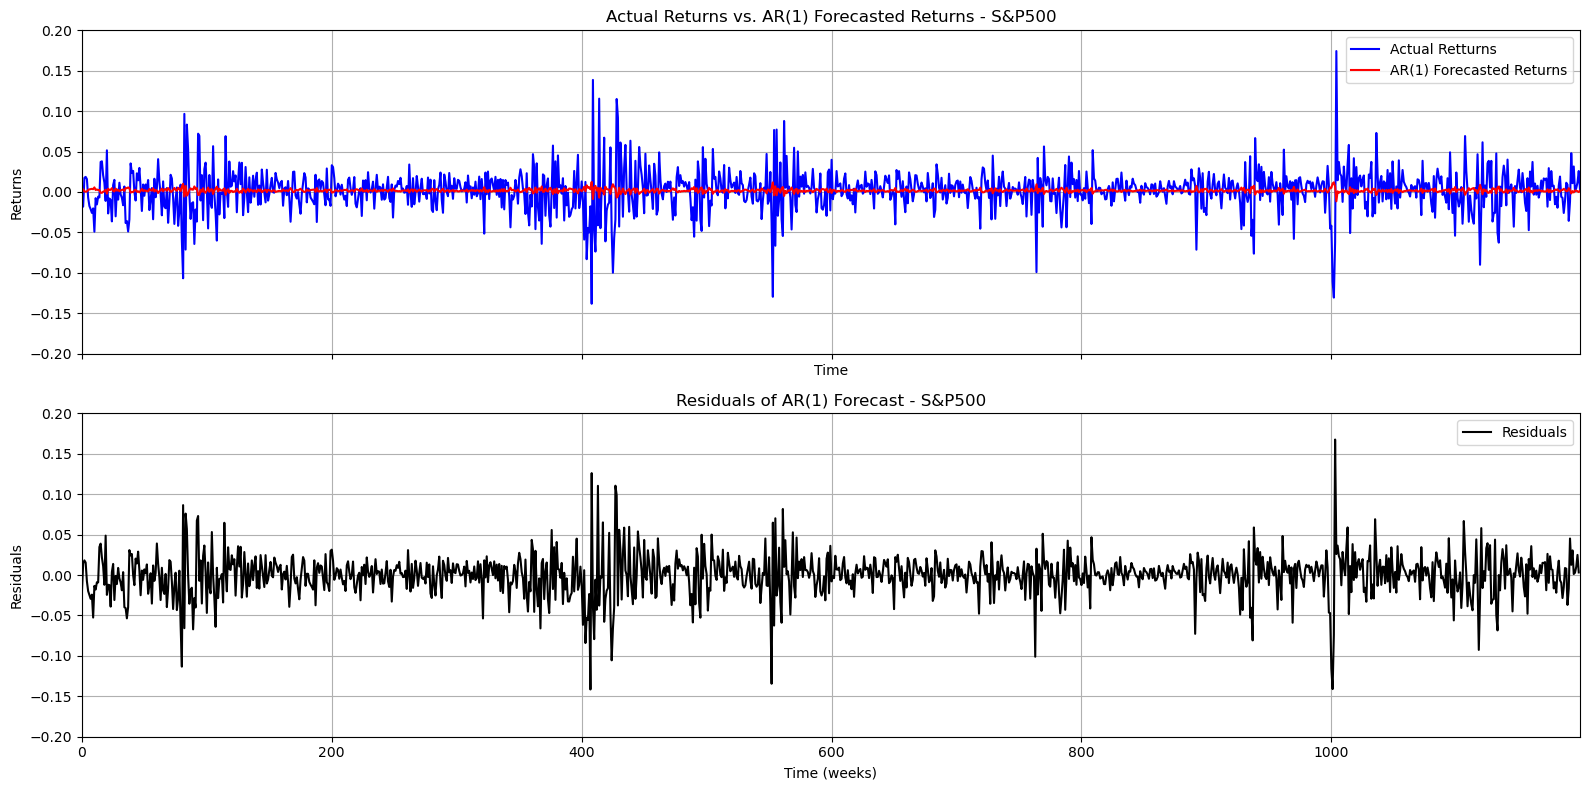

In [16]:
returns_sp500_reset = returns_sp500.reset_index(drop=True)
exp_returns_sp_reset = exp_returns_sp.reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Plotting the actual vs. forecasted returns
ax1.set_title('Actual Returns vs. AR(1) Forecasted Returns - S&P500')
ax1.plot(returns_sp500_reset, label='Actual Retturns', color='blue')
ax1.plot(exp_returns_sp_reset, label='AR(1) Forecasted Returns', color='red')
ax1.grid()
ax1.set_xlabel('Time')
ax1.set_ylabel('Returns')
ax1.set_xlim(0, len(returns_sp500_reset))
ax1.set_ylim(-0.2, 0.2)
ax1.legend()

# Plotting the residuals
ax2.set_title('Residuals of AR(1) Forecast - S&P500')
ax2.plot(residuals_sp500, label='Residuals', color='black')
ax2.grid()
ax2.set_xlabel('Time (weeks)')
ax2.set_ylabel('Residuals')
ax2.set_ylim(-0.2, 0.2)
ax2.set_xlim(0, len(residuals_sp500))
ax2.legend()

plt.tight_layout()
plt.show()

Q3.1

In [17]:
Ellipsis

Ellipsis

Q3.2

Total return dynamic L2: 3.472345864708841
Total return static L2: 1.8805832538350384
Static L2 Sharpe: 0.06839721830157934
Dynamic L2 Sharpe: 0.0813877123697702
Volatility dynamic L2: 0.09203014049853314
Volatility static L2: 0.02915057026811288


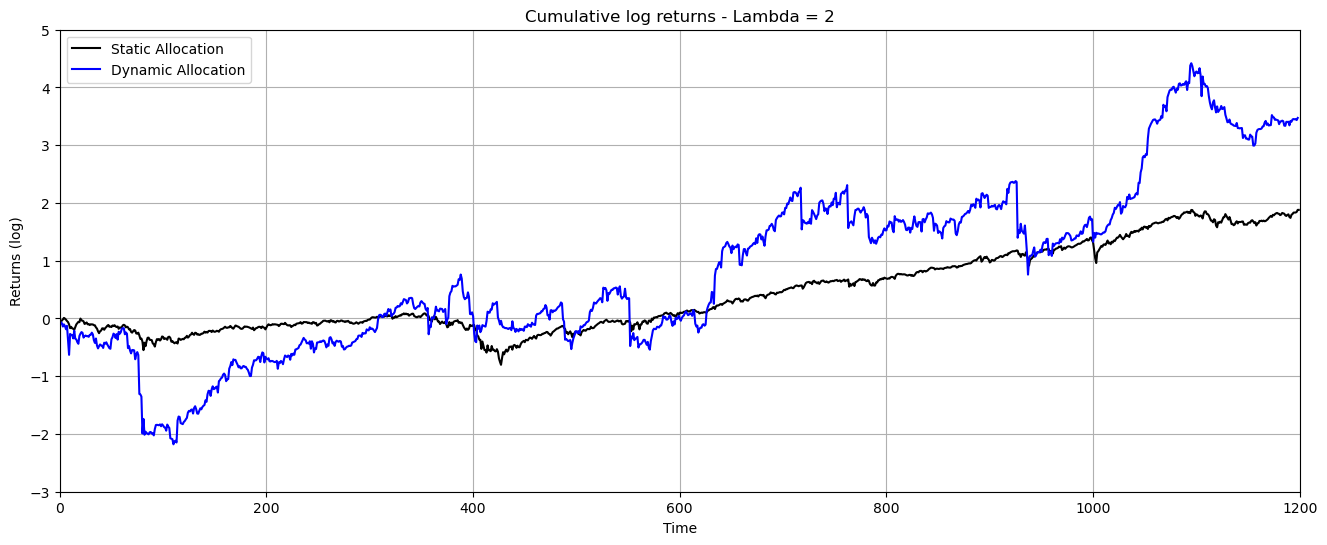

In [18]:
plt.figure(figsize=(16, 6))
plt.title('Cumulative log returns - Lambda = 2')
plt.plot(log_static_returns_cum_L2, label='Static Allocation', color='black')
plt.plot(log_dynamic_returns_cum_L2, label='Dynamic Allocation', color='blue')
plt.grid()
plt.xlim(0, 1200)
plt.xlabel('Time')
plt.ylabel('Returns (log)')
plt.ylim(-3, 5)
plt.legend()
print('Total return dynamic L2:', log_dynamic_returns_cum_L2[-1])
print('Total return static L2:', log_static_returns_cum_L2[-1])
print('Static L2 Sharpe:', np.mean(static_returns_L2) / np.std(static_returns_L2, ddof=0))
print('Dynamic L2 Sharpe:', np.mean(dynamic_returns_L2) / np.std(dynamic_returns_L2, ddof=0))
print('Volatility dynamic L2:', np.std(dynamic_returns_L2, ddof=0))
print('Volatility static L2:', np.std(static_returns_L2, ddof=0))

Total return static L10: 0.7667633497716733
Total return dynamic L10: 1.8987093779620412
Static L10 Sharpe: 0.11272876328584903
Dynamic L10 Sharpe: 0.09538415745440974
Volatility dynamic L10: 0.018398130382761963
Volatility static L10: 0.005820191535690346


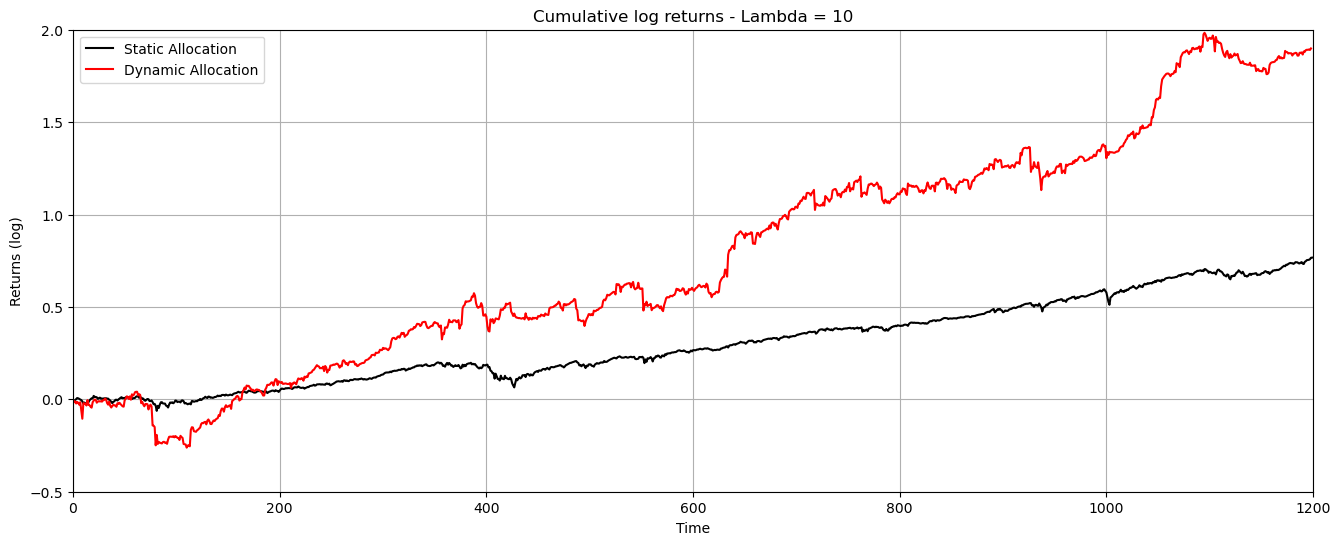

In [19]:
plt.figure(figsize=(16, 6))
plt.title('Cumulative log returns - Lambda = 10')
plt.plot(log_static_returns_cum_L10, label='Static Allocation', color='black')
plt.plot(log_dynamic_returns_cum_L10, label='Dynamic Allocation', color='red')
plt.grid()
plt.xlim(0, 1200)
plt.xlabel('Time')
plt.ylabel('Returns (log)')
plt.ylim(-0.5, 2)
plt.legend()
print('Total return static L10:', log_static_returns_cum_L10[-1])
print('Total return dynamic L10:', log_dynamic_returns_cum_L10[-1])
print('Static L10 Sharpe:', np.mean(static_returns_L10) / np.std(static_returns_L10, ddof=0))
print('Dynamic L10 Sharpe:', np.mean(dynamic_returns_L10) / np.std(dynamic_returns_L10, ddof=0))
print('Volatility dynamic L10:', np.std(dynamic_returns_L10, ddof=0))
print('Volatility static L10:', np.std(static_returns_L10, ddof=0))

Q3.3

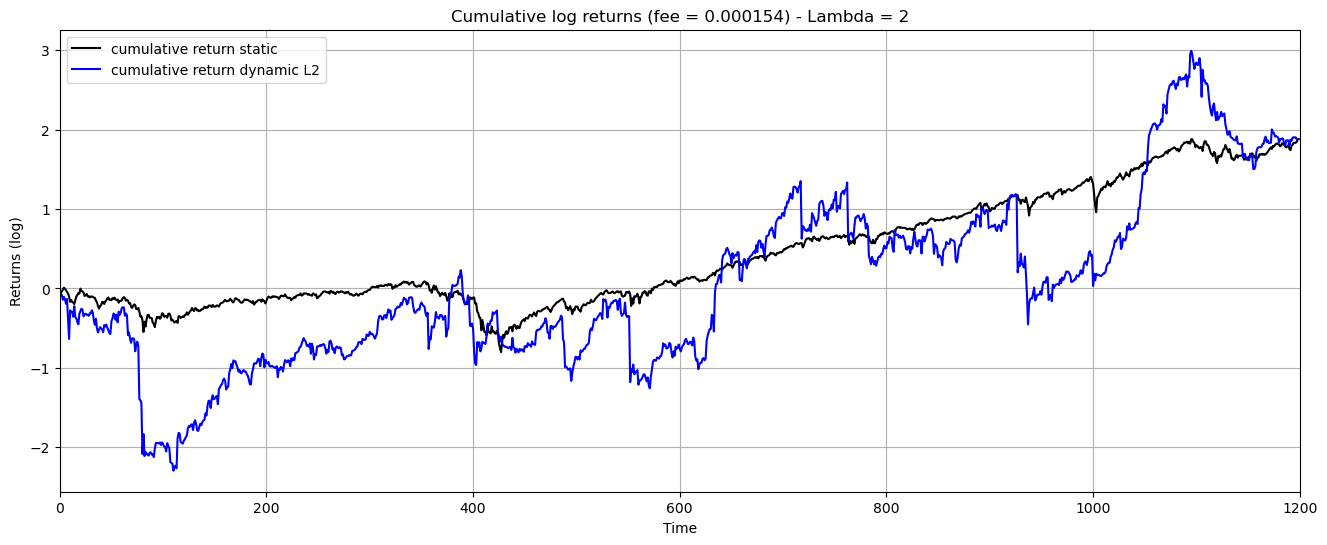

Optimal fee L2: 0.00015429687500000003


In [20]:
plt.figure(figsize=(16, 6))
plt.title(f'Cumulative log returns (fee = {round(F_L2[0], 6)}) - Lambda = 2')
plt.plot(log_static_returns_cum_L2, label='cumulative return static', color='black', linestyle='-')
plt.plot(log_dynamic_cumreturns_L2_withF, label='cumulative return dynamic L2', color='blue', linestyle='-')
# plt.plot(log_dynamic_cumreturns_L10_withF, label='cumulative return dynamic L10', color='red', linestyle='-')
# plt.plot(log_static_returns_cum_L10, label='cumulative return static', color='blue', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Returns (log)')
plt.xlim(0, 1200)
plt.legend()
plt.grid(True)
plt.show()
print('Optimal fee L2:', F_L2[0])

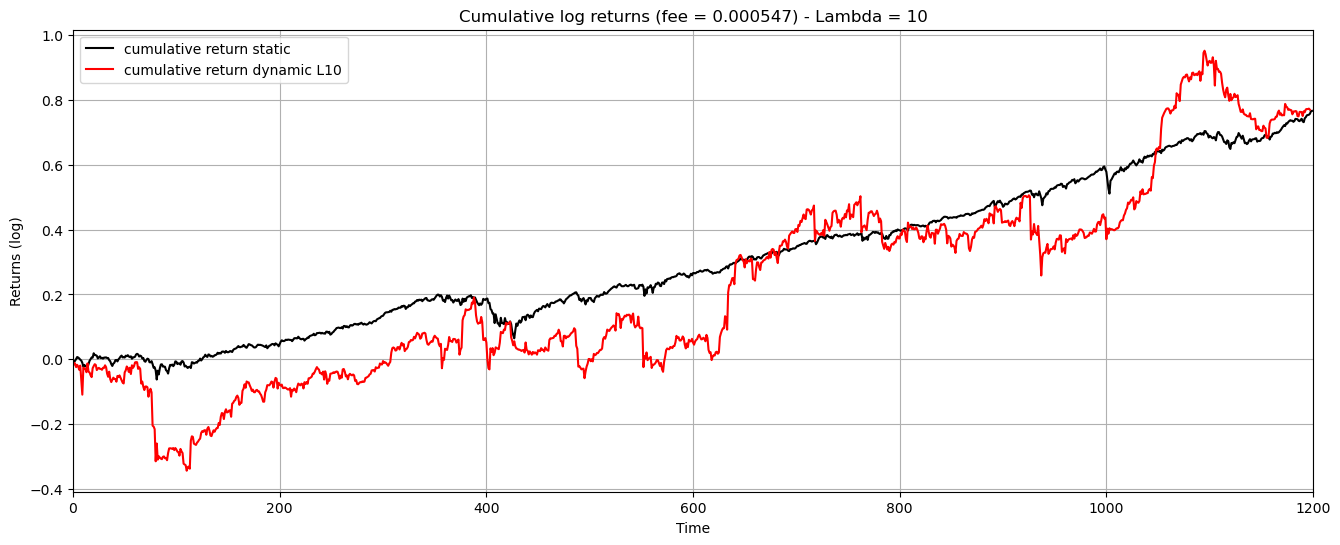

Optimal fee L10: 0.000546875


In [21]:
plt.figure(figsize=(16, 6))
plt.title(f'Cumulative log returns (fee = {round(F_L10[0], 6)}) - Lambda = 10')
plt.plot(log_static_returns_cum_L10, label='cumulative return static', color='black', linestyle='-')
plt.plot(log_dynamic_cumreturns_L10_withF, label='cumulative return dynamic L10', color='red', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Returns (log)')
plt.xlim(0, 1200)
plt.legend()
plt.grid(True)
plt.show()
print('Optimal fee L10:', F_L10[0])

Q4.1

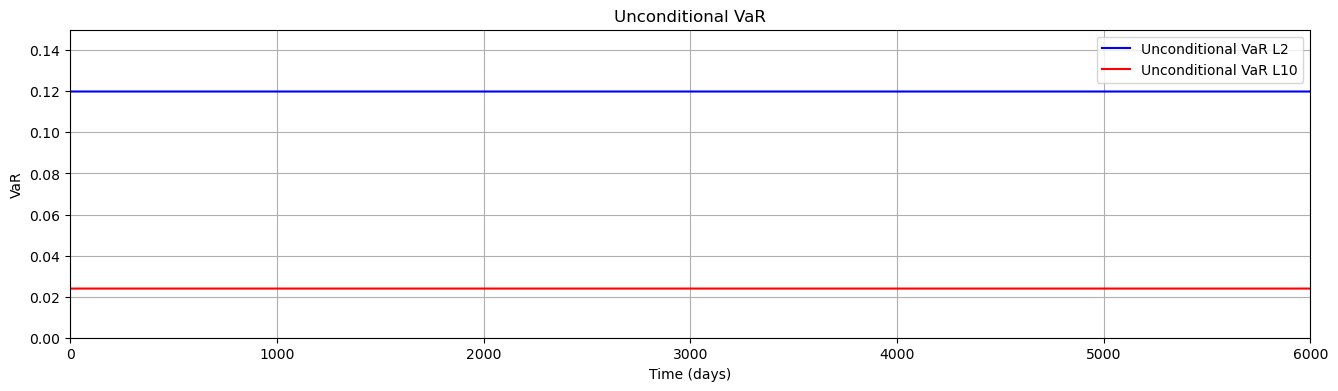

In [22]:
plt.figure(figsize=(16, 4))
plt.title('Unconditional VaR')
plt.plot(np.repeat(uncond_var_L2, len(loss_L2)), label='Unconditional VaR L2', color='blue')
plt.plot(np.repeat(uncond_var_L10, len(loss_L10)), label='Unconditional VaR L10', color='red')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('VaR')
plt.ylim(0, 0.15)
plt.xlim(0, 6000)
plt.legend()

Q4.2

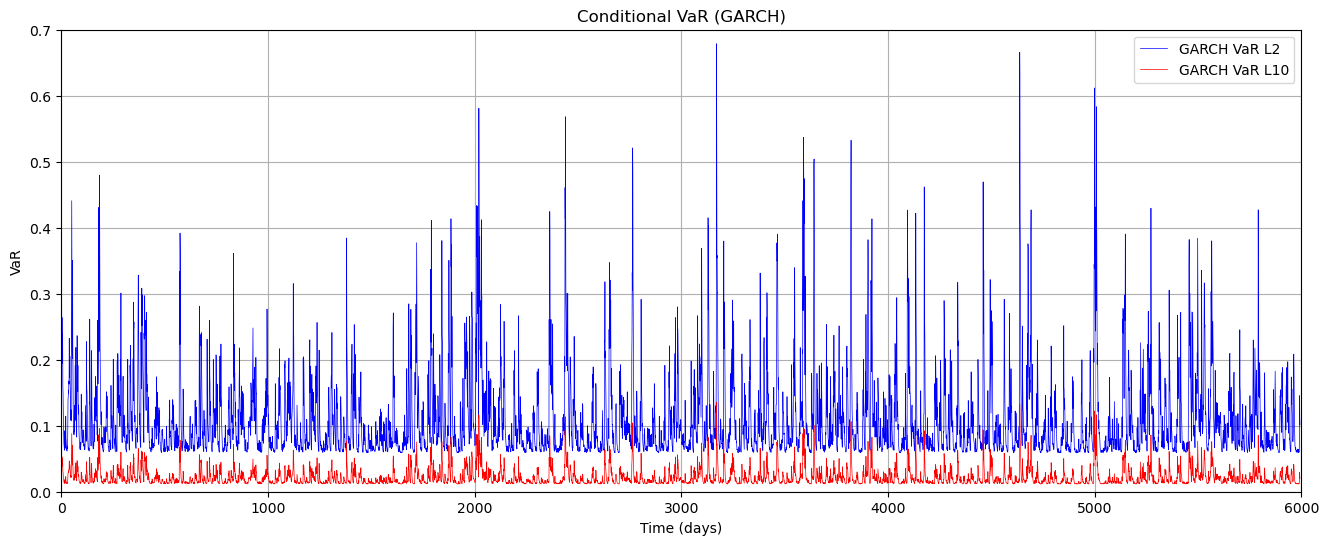

In [23]:
plt.figure(figsize=(16, 6))
plt.title('Conditional VaR (GARCH)')
plt.plot(garch_conditional_var_L2, label='GARCH VaR L2', color='blue', linewidth=0.5)
plt.plot(garch_conditional_var_L10, label='GARCH VaR L10', color='red', linewidth=0.5)
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('VaR')
plt.ylim(0, 0.7)
plt.xlim(0, 6000)
plt.legend()

Q4.3

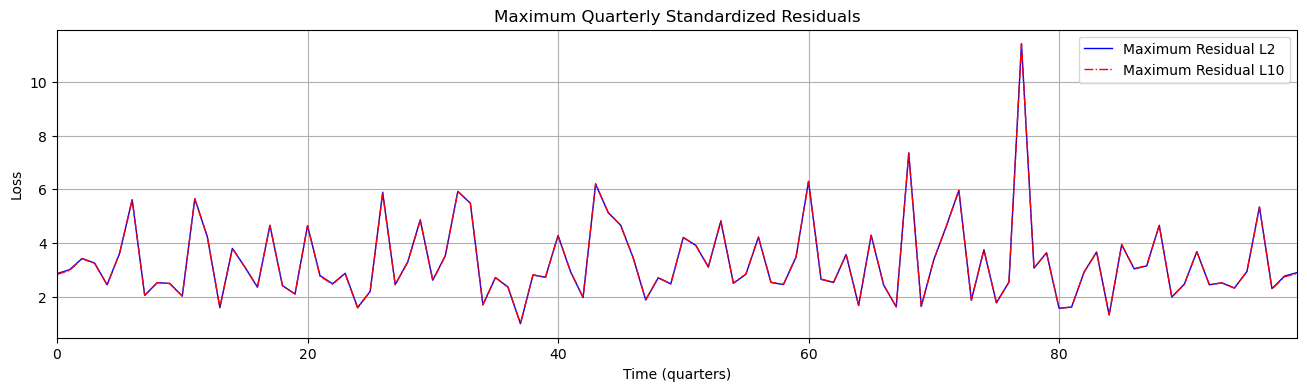

In [24]:
plt.figure(figsize=(16, 4))
plt.title('Maximum Quarterly Standardized Residuals')
plt.plot(maximum_quarterly_standardized_residuals_L2, label='Maximum Residual L2', color='blue', linewidth=1, linestyle='-')
plt.plot(maximum_quarterly_standardized_residuals_L10, label='Maximum Residual L10', color='red', linewidth=1, linestyle='-.')
plt.grid()
plt.xlabel('Time (quarters)')
plt.ylabel('Loss')
plt.xlim(0, 99)
plt.legend()

Q4.5

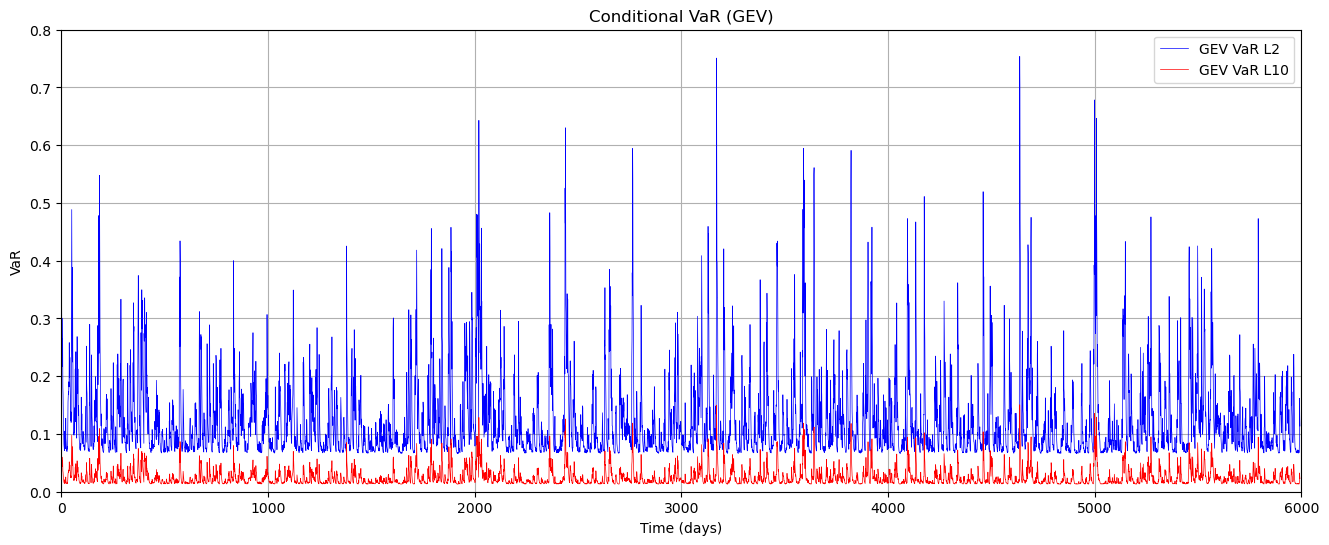

In [25]:
plt.figure(figsize=(16, 6))
plt.title('Conditional VaR (GEV)')
plt.plot(VaR_gev_L2, label='GEV VaR L2', color='blue', linewidth=0.5)
plt.plot(VaR_gev_L10, label='GEV VaR L10', color='red', linewidth=0.5)
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('VaR')
plt.ylim(0, 0.8)
plt.xlim(0, 6000)
plt.legend()

Q4.6

Lambda 2

Max: 0.7537339518933112


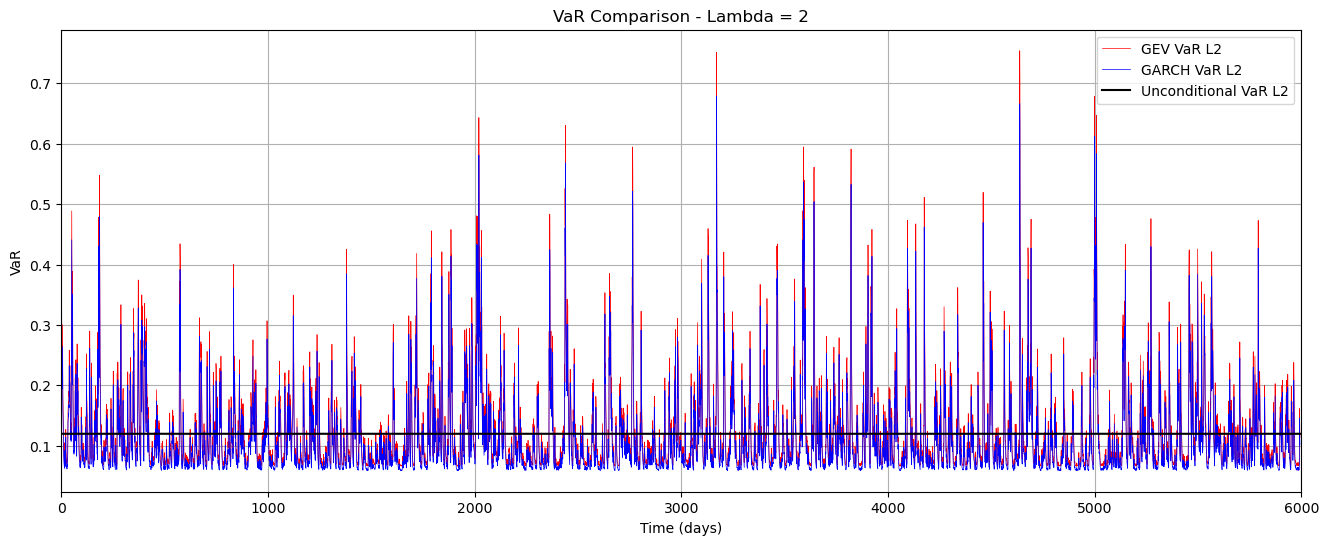

In [26]:
plt.figure(figsize=(16, 6))
plt.title('VaR Comparison - Lambda = 2')
plt.plot(VaR_gev_L2, label='GEV VaR L2', color='red', linewidth=0.5)
plt.plot(garch_conditional_var_L2, label='GARCH VaR L2', color='blue', linewidth=0.5)
plt.plot(np.repeat(uncond_var_L2, len(loss_L2)), label='Unconditional VaR L2', color='black')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('VaR')
# plt.ylim(0, 0.15)
plt.xlim(0, 6000)
plt.legend()

print('Max:', np.max(VaR_gev_L2))

Lambda 10

Max: 0.15058413707666735
4.929458568776411
5.008637343181026
0.3453375737779911
1.620609361134394


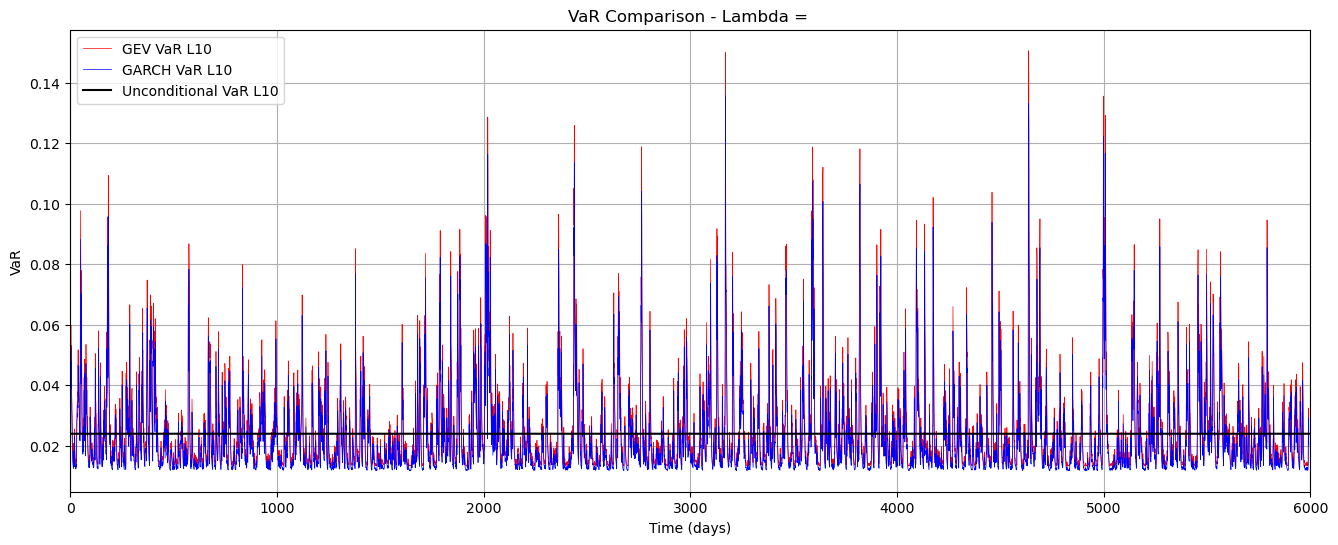

In [27]:
plt.figure(figsize=(16, 6))
plt.title('VaR Comparison - Lambda = ')
plt.plot(VaR_gev_L10, label='GEV VaR L10', color='red', linewidth=0.5)
plt.plot(garch_conditional_var_L10, label='GARCH VaR L10', color='blue', linewidth=0.5)
plt.plot(np.repeat(uncond_var_L10, len(loss_L10)), label='Unconditional VaR L10', color='black')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('VaR')
# plt.ylim(0, 0.7)
plt.xlim(0, 6000)
plt.legend()
print('Max:', np.max(VaR_gev_L10))
x = VaR_gev_L10
y = VaR_gev_L2
print(x @ x.T)
beta = x.T @ y / (x.T @ x)

print(beta)
print(np.sum(y - beta * x))
print(np.sum(y - 5 * x))